In [1]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 317 (delta 9), reused 14 (delta 5), pack-reused 297
Receiving objects: 100% (317/317), 541.74 KiB | 1.51 MiB/s, done.
Resolving deltas: 100% (181/181), done.
/content/emotenn


In [0]:
%tensorflow_version 2.x
import os
import cv2
import numpy as np
import tensorflow as tf
from emotenn import constants as ct, load_utils as lu, train_utils as tu, plot_utils as pu
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Convolution2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import applications
from sklearn.model_selection import train_test_split

In [4]:
X, Y = lu.load_dataset(ct.FER2013)
img_count, w, h, _ = X.shape
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = tu.split_dataset(X, Y, test_size=0.15, valid_size=0.2, align_by=256)
print(f'Train data dimensions: {X_train.shape}')
print(f'Validation data dimensions: {X_valid.shape}')
print(f'Test data dimensions: {X_test.shape}')

Train data dimensions: (23296, 48, 48, 1)
Validation data dimensions: (7194, 48, 48, 1)
Test data dimensions: (5397, 48, 48, 1)


In [5]:
strategy = tu.get_distribution_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [0]:
# Load vgg model with face weights
vgg_weights_file = ct.GDriveFile('1nTQnuc_-bowCaBNQo5SmRiwEhTv_H72M', os.path.join(ct.RESULTS_DIR, 'vgg_weights.h5'))
lu.download_file_from_google_drive(vgg_weights_file, exist_ok=True)

In [0]:
def build_model(features_count, labels_count, input_width, input_height):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    #model.add(Activation('relu'))

    model.load_weights(vgg_weights_file.path)
    for layer in model.layers[:-1]:
        layer.trainable = False

    vgg = model
    #x = vgg.output

    x = vgg.layers[-4].output
    x = Flatten()(x)
    x = Dense(2000, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1000, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(labels_count)(x)
    predictions = Activation('softmax')(x)

    result_model = Model(inputs=vgg.input, outputs=predictions)
    print(result_model.summary())
    return result_model

    # RESNET PART
    #resnet = applications.ResNet101(include_top=False, weights='imagenet', input_shape=(w, h, 3))
    #vgg = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (w, h, 3))
    #x = resnet.layers[-40].output
    #x = resnet.output
    #x = Flatten()(x)
    # print(x.shape)
    # vgg.summary()
    # hidden = MaxPooling2D(pool_size=(2,2))(). vgg.layers[-1].output
    # vgg.summary()

    #model = Sequential()

    # x = Conv2D(features_count, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # #x = Conv2D(features_count, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # #x = BatchNormalization()(x)
    # x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    # x = Dropout(0.5)(x)

    # x = Conv2D(2*features_count, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Conv2D(2*features_count, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    # x = Dropout(0.5)(x)

    # x = Conv2D(2*2*features_count, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Conv2D(2*2*features_count, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    # x = Dropout(0.5)(x)

    # x = Conv2D(2*2*2*features_count, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Conv2D(2*2*2*features_count, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    # x = Dropout(0.5)(x)

    # x = Dense(2*2*2*features_count, activation='relu')(x)
    # x = Dropout(0.4)(x)
    # x = Dense(2*2*features_count, activation='relu')(x)
    # x = Dropout(0.4)(x)
    # x = Dense(2*features_count, activation='relu')(x)
    # x = Dropout(0.5)(x)

    # x = Flatten()(x)
    # x = Dense(1024, activation='relu')(x)
    # x = Dropout(0.3)(x)
    # x = Dense(1024, activation='relu')(x)
    # x = Dropout(0.3)(x)
    # predictions = Dense(labels_count, activation='softmax')(x)

    # my_model = Model(inputs=vgg.input, outputs=predictions)
    # print(model.summary())
    # for layer in my_model.layers[:-3]:
    #    layer.trainable = False
    # return my_model

features_count = 64
labels_count = 7

with strategy.scope():
    model = build_model(features_count, labels_count, w, h)
    model.compile(loss=categorical_crossentropy,
                  optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_26_input (Inp [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 114, 114, 64)      0   

In [0]:
class BaseSequence(tf.keras.utils.Sequence):
    def __init__(self, x, y, batch_size=64):
        self.x, self.y = x, y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

    @staticmethod
    def preprocess(img):
        colored_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        return cv2.resize(colored_img, (224, 224), interpolation=cv2.INTER_LINEAR)


class ProcessingSequence(BaseSequence):
    def __getitem__(self, idx):
        orig_batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = np.zeros((len(orig_batch_x), 224, 224, 3))
        for i, orig_img in enumerate(orig_batch_x):
            batch_x[i] = self.preprocess(orig_batch_x[i])
        return batch_x, batch_y


class MemmapSequence(BaseSequence):
    def __init__(self, x, y, name, batch_size=64):
        memmap_file_path = os.path.join(os.sep, 'content', name)
        mode = 'r+' if os.path.exists(memmap_file_path) else 'w+'
        mm_x = np.memmap(memmap_file_path, dtype=x.dtype, mode=mode, shape=((len(x), 224, 224, 3)))
        if mode == 'w+':
            for i, img in enumerate(x):
                mm_x[i] = self.preprocess(img)
        super().__init__(mm_x, y, batch_size)


class MemorySequence(BaseSequence):
    def __init__(self, x, y, batch_size=64):
        new_x = np.zeros((len(x), 224, 224, 3), dtype=x.dtype)
        for i, img in enumerate(x):
                new_x[i] = self.preprocess(img)
        super().__init__(new_x, y, batch_size)


In [0]:
train_data = ProcessingSequence(X_train, Y_train)
valid_data = ProcessingSequence(X_valid, Y_valid)
test_data = ProcessingSequence(X_test, Y_test)

# train_data = MemmapSequence(X_train, Y_train, 'train.bin')
# valid_data = MemmapSequence(X_valid, Y_valid, 'valid.bin')
# test_data = MemmapSequence(X_test, Y_test, 'test.bin')

# train_data = MemorySequence(X_train, Y_train)
# valid_data = MemorySequence(X_valid, Y_valid)
# test_data = MemorySequence(X_test, Y_test)

In [0]:
def get_callbacks(model_name):
    os.makedirs(ct.CHECKPOINTS_DIR, exist_ok=True)

    cb_list = []
    cb_list.append(callbacks.ModelCheckpoint(os.path.join(ct.CHECKPOINTS_DIR, model_name + '-checkpoint.h5'), period=5, save_best_only=True))
    cb_list.append(callbacks.EarlyStopping(monitor='val_accuracy', patience=15))
    return cb_list

In [0]:
batch_size = 256
epochs = 50
model_name = 'transfer_learning'

for data in [train_data, valid_data, test_data]:
    data.batch_size = batch_size

cb = get_callbacks(model_name)
# train_history = model.fit(X_train,
#                           Y_train,
#                           batch_size=batch_size,
#                           epochs=epochs,
#                           validation_data=(X_valid, Y_valid),
#                           shuffle=True)
# train_history = model.fit(train_data.x,
#                           train_data.y,
#                           batch_size=batch_size,
#                           epochs=epochs,
#                           validation_data=(valid_data.x, valid_data.y),
#                           shuffle=True)
train_history = model.fit(x=train_data,
                          validation_data=valid_data,
                          callbacks=cb,
                          epochs=epochs)

Epoch 1/50
91/91 [==============================] - 82s 901ms/step - accuracy: 0.4127 - loss: 1.5408 - val_accuracy: 0.5296 - val_loss: 1.3024
Epoch 2/50
91/91 [==============================] - 82s 901ms/step - accuracy: 0.5331 - loss: 1.2591 - val_accuracy: 0.5531 - val_loss: 1.2202
Epoch 3/50
91/91 [==============================] - 82s 900ms/step - accuracy: 0.5653 - loss: 1.1840 - val_accuracy: 0.5613 - val_loss: 1.1937
Epoch 4/50
91/91 [==============================] - 81s 889ms/step - accuracy: 0.5820 - loss: 1.1281 - val_accuracy: 0.5727 - val_loss: 1.1602
Epoch 5/50
91/91 [==============================] - 83s 917ms/step - accuracy: 0.6010 - loss: 1.0859 - val_accuracy: 0.5767 - val_loss: 1.1427
Epoch 6/50
91/91 [==============================] - 82s 901ms/step - accuracy: 0.6131 - loss: 1.0458 - val_accuracy: 0.5848 - val_loss: 1.1322
Epoch 7/50
91/91 [==============================] - 82s 902ms/step - accuracy: 0.6339 - loss: 1.0035 - val_accuracy: 0.5819 - val_loss: 1.1261

22/22 [==============================] - 14s 615ms/step - accuracy: 0.6313 - loss: 1.4401
Dataset accuracy: 63.13%


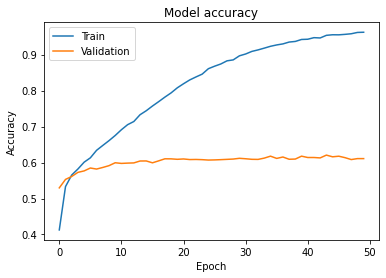

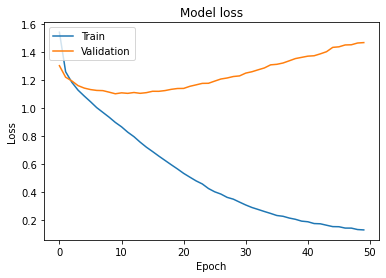

In [0]:
#score = model.evaluate(X_test, Y_test)
#score = model.evaluate(test_data.x, test_data.y)
score = model.evaluate(x=test_data)
print("Dataset {}: {:.2f}%".format(model.metrics_names[1], score[1] * 100))
pu.plot_model_history(train_history.history)

In [0]:
tu.save_results(model, train_history, model_name)

Model is saved to /content/emotenn/trained_models/model.h5
Train history is saved to /content/emotenn/trained_models/model_history.pkl


In [0]:
train_history = model.fit(x=train_data,
                          validation_data=valid_data,
                          callbacks=callbacks,
                          epochs=epochs)

Epoch 1/100
91/91 [==============================] - 81s 892ms/step - loss: 1.3027 - accuracy: 0.5160 - val_loss: 1.2786 - val_accuracy: 0.5399
Epoch 2/100
91/91 [==============================] - 81s 890ms/step - loss: 1.3013 - accuracy: 0.5187 - val_loss: 1.2779 - val_accuracy: 0.5402
Epoch 3/100
91/91 [==============================] - 81s 892ms/step - loss: 1.3029 - accuracy: 0.5152 - val_loss: 1.2773 - val_accuracy: 0.5403
Epoch 4/100
91/91 [==============================] - 81s 892ms/step - loss: 1.3014 - accuracy: 0.5153 - val_loss: 1.2768 - val_accuracy: 0.5406
Epoch 5/100
91/91 [==============================] - 82s 902ms/step - loss: 1.3011 - accuracy: 0.5137 - val_loss: 1.2765 - val_accuracy: 0.5406
Epoch 6/100
91/91 [==============================] - 81s 891ms/step - loss: 1.2976 - accuracy: 0.5157 - val_loss: 1.2756 - val_accuracy: 0.5417
Epoch 7/100
91/91 [==============================] - 81s 891ms/step - loss: 1.3016 - accuracy: 0.5157 - val_loss: 1.2753 - val_accuracy:

KeyboardInterrupt: ignored

22/22 [==============================] - 13s 613ms/step - loss: 1.2805 - accuracy: 0.5425
Dataset accuracy: 54.25%


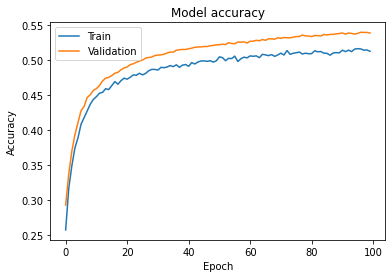

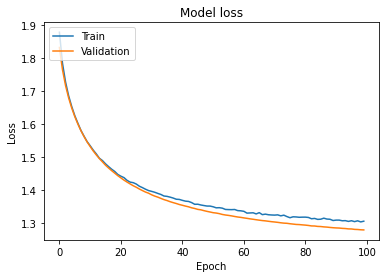

In [0]:
score = model.evaluate(x=test_data)
print("Dataset {}: {:.2f}%".format(model.metrics_names[1], score[1] * 100))
pu.plot_model_history(train_history.history)